# Loans Data Exploration

## Table of Contents
- [ ] Preliminary Wrangling
- [ ] Univariate Exploration
- [ ] Bi-Variate Exploration
- [ ] Multi-variate Exploration

## 1 Preliminary Wrangling
This document explores a dataset containing metadata related to loans such as: 
- The type of loan, duration, amount, etc, to
- Customers employment information that would impact there borrowing power i.e. credit rating, job type, etc. <br>
`Additional variables provided in the data dictionary, Prosper Loan Data`

In [1]:
#pip install pandasgui

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# for pandasgui dataframe viewer
#from pandasgui import show

%matplotlib inline

In [3]:
#load from Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Google colab read csv
loans_raw = pd.read_csv('/content/drive/My Drive/Colab Notebooks/prosperLoanData.csv')

# Local drive read csv
#loans_raw = pd.read_csv('prosperLoanData.csv')

## Functions

In [5]:
# FUNCTION TO PLOT VALS ALONG X-AXIS, NOMINAL VALS ON Y
def yplot_values(gx, form):
    initialx = 0

    for g in gx.patches:
        gx.text(g.get_width(), initialx + g.get_height()/4,
                form.format(g.get_width()),
                color='black',
                ha="left") 
        initialx+=1

In [6]:
# FUNCTION TO PLOT VALS ALONG Y-AXIS, NOMINAL VALS ON X
def xplot_values(gy, form):
    initialy = 0
    
    # Logic to print the proportion text on the bars
    for g in gy.patches:
        gy.text(initialy + g.get_width()/13, g.get_height(), 
        form.format(g.get_height()), 
        color='black',
        ha='center', # 'center', 'right', 'left'
        va='bottom') # 'top', 'bottom', 'center', 'baseline', 'center_baseline'
        initialy+=1

In [7]:
loans_raw.shape # review shape of dataset

(113937, 81)

In [8]:
loans_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  EstimatedLoss

### 1.1 Data Structure
There are 113,937 entries, across 81 variables (as seen above) in this loans dataset.
Below are the variables of interest during this exploration.

In [9]:
# create list
subset = ['EmploymentStatus', 'BorrowerState', 'Occupation', 
'CreditGrade', 'ProsperScore', 'ProsperRating (Alpha)', 
'IncomeRange', 'Term', 'CurrentDelinquencies', 'BorrowerRate', 'DebtToIncomeRatio', 
'ListingCreationDate', 'ClosedDate', 'MonthlyLoanPayment']

# 'ListingCategory (numeric)', - removed to be added later

subset, print('Number of Target Columns: {}\n'.format(len(subset)))

Number of Target Columns: 14



(['EmploymentStatus',
  'BorrowerState',
  'Occupation',
  'CreditGrade',
  'ProsperScore',
  'ProsperRating (Alpha)',
  'IncomeRange',
  'Term',
  'CurrentDelinquencies',
  'BorrowerRate',
  'DebtToIncomeRatio',
  'ListingCreationDate',
  'ClosedDate',
  'MonthlyLoanPayment'],
 None)

#### 1.1.1 Duplicates

In [10]:
## Check for duplicate data
loans_raw.duplicated().value_counts()

False    113937
dtype: int64

### 1.2 Data Cleaning

#### 1.2.1 Data dictionary variables of interest Summary:
Before continuing any further only columns of interest will be retained for the exploration to ensure only the required variables are modified.

In [11]:
# size before modification
loans_raw.shape

(113937, 81)

In [12]:
# reload loans_df with the relevant columns, loans_raw contains the original
loans_df = loans_raw.loc[:, subset].copy()
loans_df.head()

,EmploymentStatus,BorrowerState,Occupation,CreditGrade,ProsperScore,ProsperRating (Alpha),IncomeRange,Term,CurrentDelinquencies,BorrowerRate,DebtToIncomeRatio,ListingCreationDate,ClosedDate,MonthlyLoanPayment
0,Self-employed,CO,Other,C,NaN,NaN,"$25,000-49,999",36,2.0,0.1580,0.17,2007-08-26 19:09:29.263000000,2009-08-14 00:00:00,330.43
1,Employed,CO,Professional,NaN,7.0,A,"$50,000-74,999",36,0.0,0.0920,0.18,2014-02-27 08:28:07.900000000,NaN,318.93
2,Not available,GA,Other,HR,NaN,NaN,Not displayed,36,1.0,0.2750,0.06,2007-01-05 15:00:47.090000000,2009-12-17 00:00:00,123.32
3,Employed,GA,Skilled Labor,NaN,9.0,A,"$25,000-49,999",36,4.0,0.0974,0.15,2012-10-22 11:02:35.010000000,NaN,321.45
4,Employed,MN,Executive,NaN,4.0,D,"$100,000+",36,0.0,0.2085,0.26,2013-09-14 18:38:39.097000000,NaN,563.97


#### 1.2.2 Datatypes

In [13]:
# convert to correct data types
toDates = ['ListingCreationDate', 'ClosedDate'] # date mask
loans_df[toDates] = loans_df[toDates].astype('datetime64')

In [14]:
# check datatypes are now correct
loans_df[toDates].dtypes

ListingCreationDate    datetime64[ns]
ClosedDate             datetime64[ns]
dtype: object

In [15]:
# Find ordinal variables and set order from lowest (left) to highest (right)
ordinal_dict = {'CreditGrade': ['HR','E','D','C','B','A','AA'],
                'IncomeRange': ['Not employed', '$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+']
                }

# Udacity code snippet to replace Column in existing DF with newly configured order (from above)
for var in ordinal_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_dict[var])
    
    loans_df[var] = loans_df[var].astype(ordered_var)

In [16]:
# separation of variables
numbers = ['ProsperScore', 'Term', 'CurrentDelinquencies', 'BorrowerRate', 'DebtToIncomeRatio', 'MonthlyLoanPayment']
categories = ['EmploymentStatus','BorrowerState', 'Occupation', 'CreditGrade', 'IncomeRange']

### 1.3 Univariate Exploration

#### 1.3.1 NaN/Missing Data
First visual is to grasp the amount of NaN present in the current dataset to determine whether additional cleaning is required. 

In [17]:
# create empty list to hold series data, information is held in .index (column names) and .values (number of NaN per column)
Nan_sublist_all = []
Nan_sublist_all = loans_df.isna().sum()
Nan_sublist_all.sort_values(ascending=False)

CreditGrade              85125
ClosedDate               58848
ProsperRating (Alpha)    29084
ProsperScore             29084
DebtToIncomeRatio         8554
IncomeRange               7741
BorrowerState             5515
Occupation                3588
EmploymentStatus          2255
CurrentDelinquencies       697
MonthlyLoanPayment           0
ListingCreationDate          0
BorrowerRate                 0
Term                         0
dtype: int64

In [18]:
# List above contains unnecessary entries limiting viewing.
# Add equality test to narrow down to column names with 
Nan_sublist = Nan_sublist_all[Nan_sublist_all.values > 0]

In [19]:
Nan_sublist.shape

(10,)

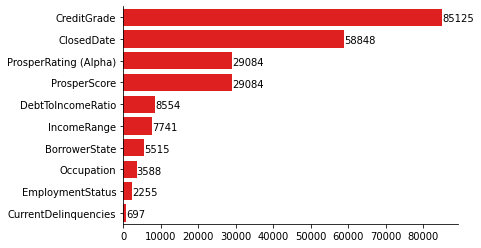

In [20]:
# explicit figure and figsize declaraction
fig, axes = plt.subplots(1,1)
sb.despine(fig)

# sort by 
g0 = sb.barplot(x=Nan_sublist.values, y=Nan_sublist.index, ax=axes, color='red', order=Nan_sublist.sort_values(ascending=False).index )

yplot_values(g0, '{:1.0f}');

plt.show()

In [21]:
loans_df.shape # review size prior to dropping Nan

(113937, 14)

In [22]:
Nan_sublist.sort_values(ascending=False)[4:].index

Index(['DebtToIncomeRatio', 'IncomeRange', 'BorrowerState', 'Occupation',
       'EmploymentStatus', 'CurrentDelinquencies'],
      dtype='object')

In [23]:
# slice object, convert to list and check datatype
subset_drop = Nan_sublist.sort_values(ascending=False)[4:].index.tolist()
subset_drop, type(subset_drop)

(['DebtToIncomeRatio',
  'IncomeRange',
  'BorrowerState',
  'Occupation',
  'EmploymentStatus',
  'CurrentDelinquencies'],
 list)

In [24]:
loans_df.dropna(axis=0, subset=subset_drop, inplace=True)

In [25]:
loans_df.shape

(94754, 14)

## 2 Exploratory data analysis
The EDA will revolve around the exploration of the 14 variables mentioned previously.

In [26]:
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94754 entries, 0 to 113936
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   EmploymentStatus       94754 non-null  object        
 1   BorrowerState          94754 non-null  object        
 2   Occupation             94754 non-null  object        
 3   CreditGrade            18410 non-null  category      
 4   ProsperScore           76224 non-null  float64       
 5   ProsperRating (Alpha)  76224 non-null  object        
 6   IncomeRange            94754 non-null  category      
 7   Term                   94754 non-null  int64         
 8   CurrentDelinquencies   94754 non-null  float64       
 9   BorrowerRate           94754 non-null  float64       
 10  DebtToIncomeRatio      94754 non-null  float64       
 11  ListingCreationDate    94754 non-null  datetime64[ns]
 12  ClosedDate             41550 non-null  datetime64[ns]
 13  

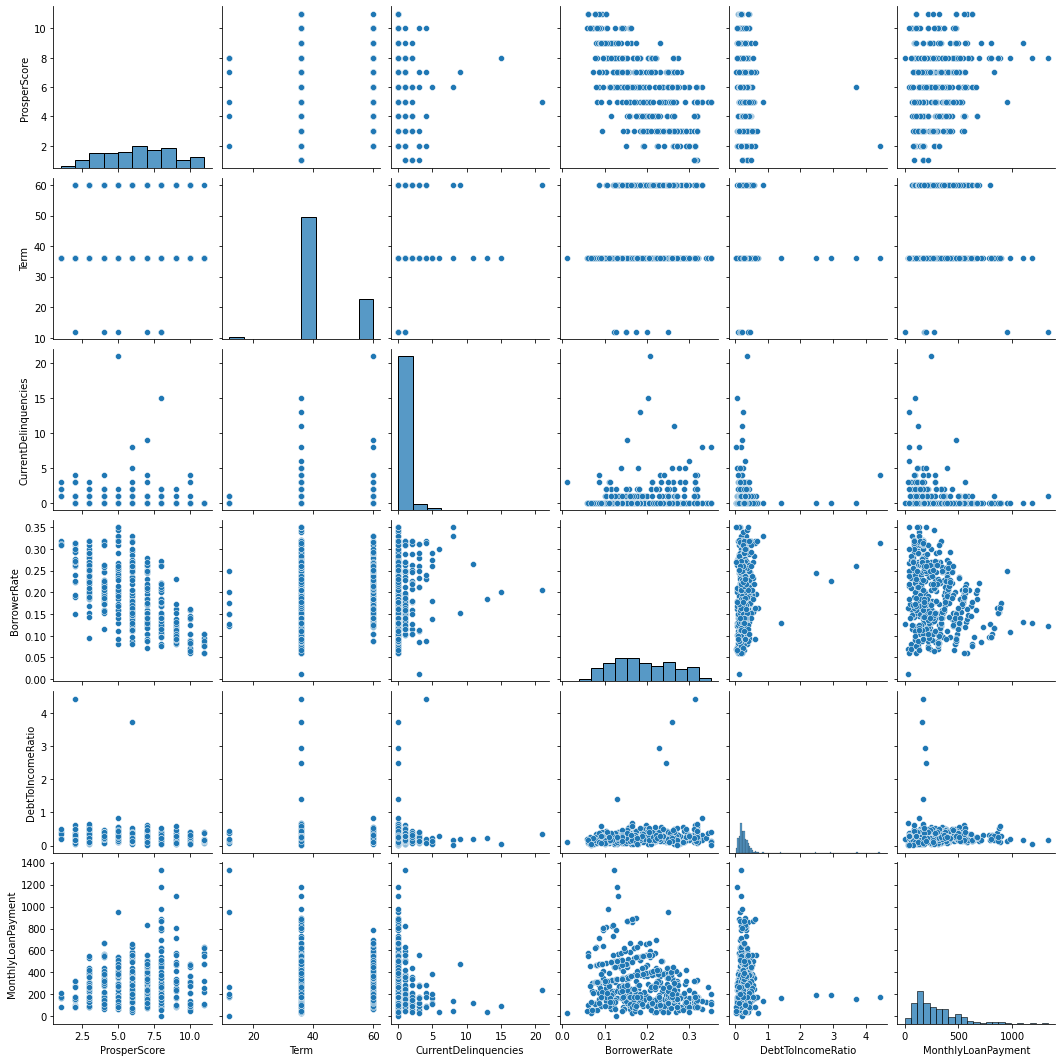

In [27]:
loans_samples = loans_df.sample(n=500)

sb.pairplot(loans_samples,
            kind='scatter',
            dropna=True,
            height=2.5
            );

Of the 500 random samples:<br>
- **Prosper score** shows a normal distribution, with a weak negative correlation to **BorrowRate** and a weak positive correlation with **MonthlyLoanPayment**.
- Term only is left skewed, with 3 main values.
- **CurrentDelinquencies** is right skewed, with possibly a weak positive correlation to **BorrowRate** and a weak negative correlation to **MonthlyLoanRepayment**.
- **BorrowRate** appears bimodal.
- **DebtIncome** appears heavily right skewed with a large peak of values around 0.
- **MonthlyLoanPayment** is right skewed.

Of the quantitative variables, we will investigate **Prosper Score, Borrowrate, MonthlyLoanPayment, CurrentDelinquincies** to clarify the correlations seen above.

### 2.1 What affects a loan repayments interest rate/BorrowRate?
What factors greatly affect the BorrowRate and as a result the **MonthlyLoanPayment** of the customer?

#### 2.1.1 Borrower Rate

In [28]:
loans_df.BorrowerRate.describe()

count    94754.000000
mean         0.191104
std          0.074819
min          0.000000
25%          0.131400
50%          0.180000
75%          0.249800
max          0.360000
Name: BorrowerRate, dtype: float64

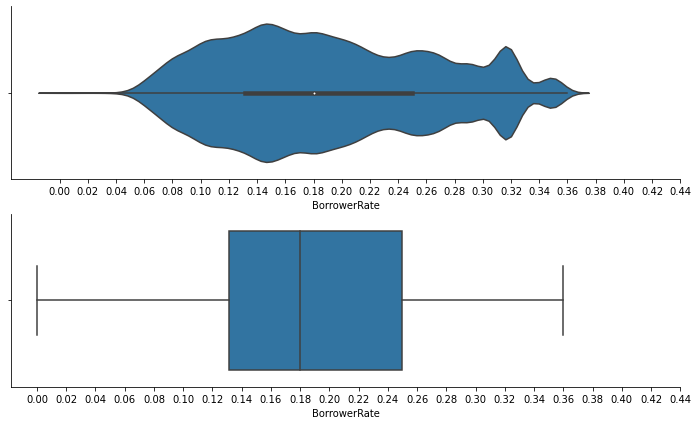

In [29]:
fig, axes = plt.subplots(2,1, figsize=(12, 7))
sb.despine(fig)

yticks_range = np.arange(0, loans_df.BorrowerRate.max()+0.1, 0.02)

g0 = sb.violinplot(x=loans_df.BorrowerRate, 
                   ax=axes[0])
g0.set_xticks( yticks_range )

g1 = sb.boxplot(x=loans_df.BorrowerRate, 
                ax=axes[1])
g1.set_xticks( yticks_range )

plt.show();

In [30]:
loans_df.BorrowerRate.median()

0.18

Both graphs approximate the median **BorrowRate** to be 18%, both plots suggest outliers to be considered ~38% and above. This allows unless to optimize the bins to be between 0 and 0.4.

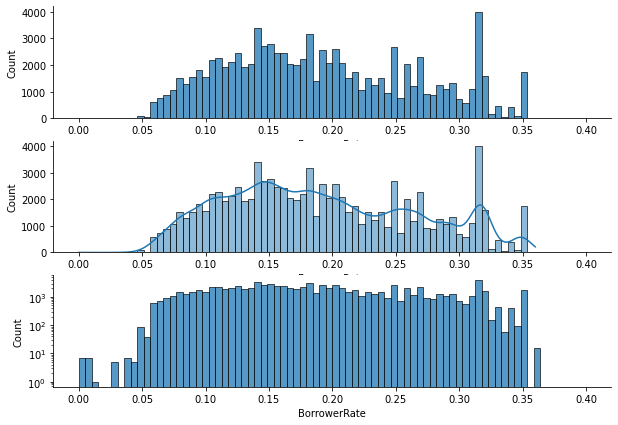

In [31]:
fig, axes = plt.subplots(3,1, figsize=(10,7))
sb.despine(fig)

# graph 1 - distribution of borrow rates
g0 = sb.histplot(loans_df,
        x='BorrowerRate',
        binrange=(0, 0.4),
        element='bars',
        multiple="stack",
        ax=axes[0]);

g1 = sb.histplot(loans_df,
        x='BorrowerRate',
        binrange=(0, 0.4),
        element='bars',
        kde=True,
        multiple="stack",
        ax=axes[1]);

axes[2].set(yscale="log")
g2 = sb.histplot(loans_df,
        x='BorrowerRate',
        binrange=(0, 0.4),
        element='bars',
        #log_scale=True,
        multiple="stack",
        ax=axes[2]);

plt.show();

BorrowRate variable shows a bi-modal normal distribution, one towards the lower end where the bulk of the customers are within 10% to 20%. The second towards the higher end with a peak at 31%.

The KDE supports that the majority under the curve are where the first normal distribution and then slowly decreases before forming another peak.

The log scale transformation reveals the outliers not seen in the prior 2 graphs above it.

#### 2.1.2 Employment Status

In [32]:
loans_df.EmploymentStatus.value_counts()

Employed         65896
Full-time        24044
Other             2194
Self-employed      973
Part-time          880
Retired            701
Not employed        66
Name: EmploymentStatus, dtype: int64

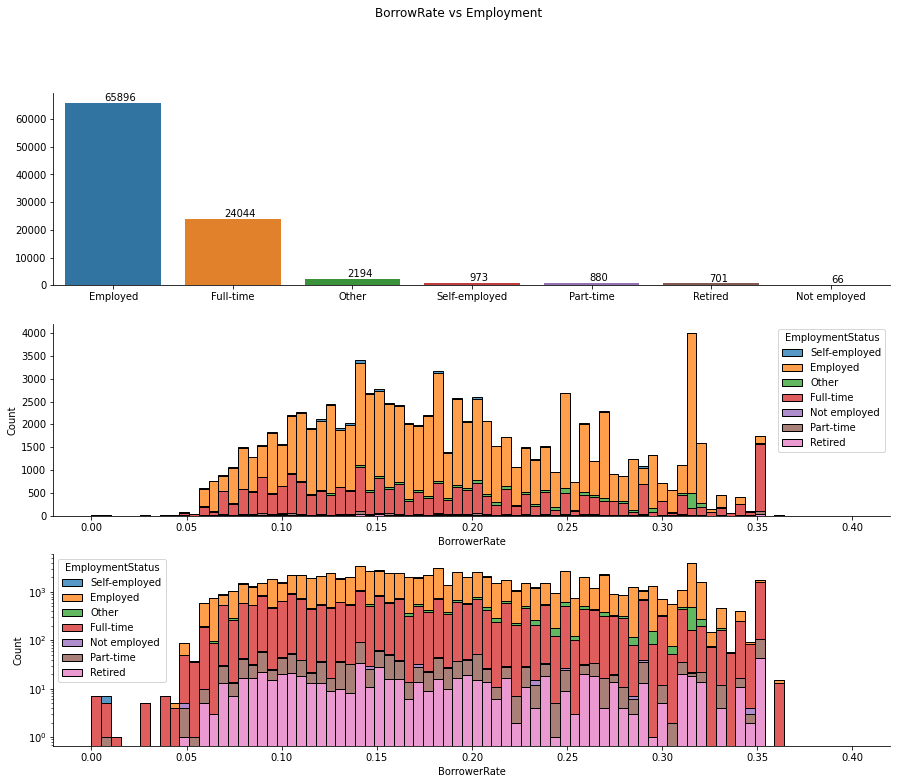

In [33]:
# subplots(row, col)
fig, axes = plt.subplots(3,1, figsize=(15,12))
sb.despine(fig)

# graph 1 - employment status
g0 = sb.barplot(x=loans_df.EmploymentStatus.value_counts().index,
        y=loans_df.EmploymentStatus.value_counts().values,
        ax=axes[0]);
xplot_values(g0, '{:1.0f}')

# graph 2 - distribution of borrow rates
g1 = sb.histplot(loans_df, 
        x='BorrowerRate',
        binrange=(0, 0.4),
        element='bars',
        hue='EmploymentStatus',
        multiple='stack',
        ax=axes[1]);


# graph 3 - log scale transformation of of graph 1 to assist in visualizing smaller values
axes[2].set(yscale="log")
g2 = sb.histplot(loans_df, 
        x='BorrowerRate',
        binrange=(0, 0.4), 
        element='bars',
        hue='EmploymentStatus',
        multiple='stack',
        ax=axes[2]);

fig.suptitle('BorrowRate vs Employment')     

plt.show();

The univariate exploration of the Employment status reveals majority of the loan applicants are 'Employed', which is redundant as it splits further into Full-time Employed, Self-Employed, Part-time, other etc meaning the data classifications were not considered appropriately.
The Bi-variate exploration against BorrowRate, reveals the spread of employment with generally revolving around 10 to 30% +/- 5%, with a large peak at ~32%.
The log transformation provides clarity for the lower values not otherwise seen in graph 2, the BorrowRates of Full-time employees receiving 0.5-1% is interesting. If they were incorrectly entered or due to the low overall amount required to be borrowed that led to such a low rate.

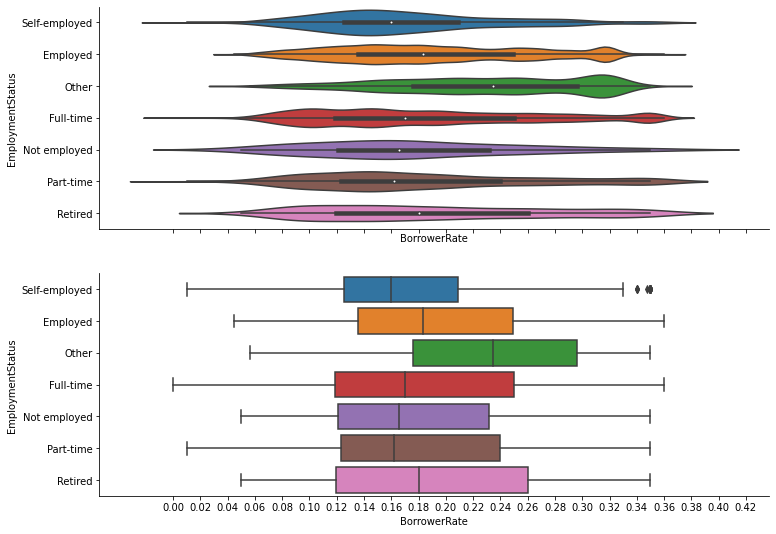

In [34]:
# subplots(row, col)
fig, axes = plt.subplots(2,1, figsize=(12, 9), sharex=True)
sb.despine(fig)

xticks_range = np.arange(0, loans_df.BorrowerRate.max()+0.08, 0.02)

g0 = sb.violinplot(
    y=loans_df.EmploymentStatus,
    x=loans_df.BorrowerRate,
    ax=axes[0]);

g1 = sb.boxplot(
    y=loans_df.EmploymentStatus,
    x=loans_df.BorrowerRate,
    ax=axes[1]);
g1.set_xticks(xticks_range);

Of the 7 employment types, the median borrow rate of **Not employed** is significantly higher then the remaining, as well a large majority of it's spread situated at the higher borrow rates due to the increased risk of the individual paying it back.

It is interesting to see at around 30% Borrower Rate, **Other** has the widest spread at ~35%, **Full-time** being the wide and tall simultaneously at ~36.

It is evident that borrower rate is affected by employment status given the **Not Employed** having a slightly lower median and smaller IQR than that of a **Full-time** employee.

In [35]:
# check shape before removal
loans_df.shape

(94754, 14)

In [36]:
# filter employmentstatus and income range
loans_df = loans_df[(loans_df.EmploymentStatus!='Not available')& (loans_df.IncomeRange!='Not displayed')]

In [37]:
# new DF size
loans_df.shape

(94754, 14)

Having **Not Available** and **Income Displayed** is redundant information that doesn't assist in the analysis of what affects BorrowRate.

#### 2.1.3 Occupation

In [38]:
loans_df.Occupation.value_counts()

Other                          23295
Professional                   12109
Computer Programmer             3907
Executive                       3810
Teacher                         3433
                               ...  
Student - College Sophomore       38
Student - College Freshman        28
Judge                             22
Student - Community College       13
Student - Technical School         7
Name: Occupation, Length: 67, dtype: int64

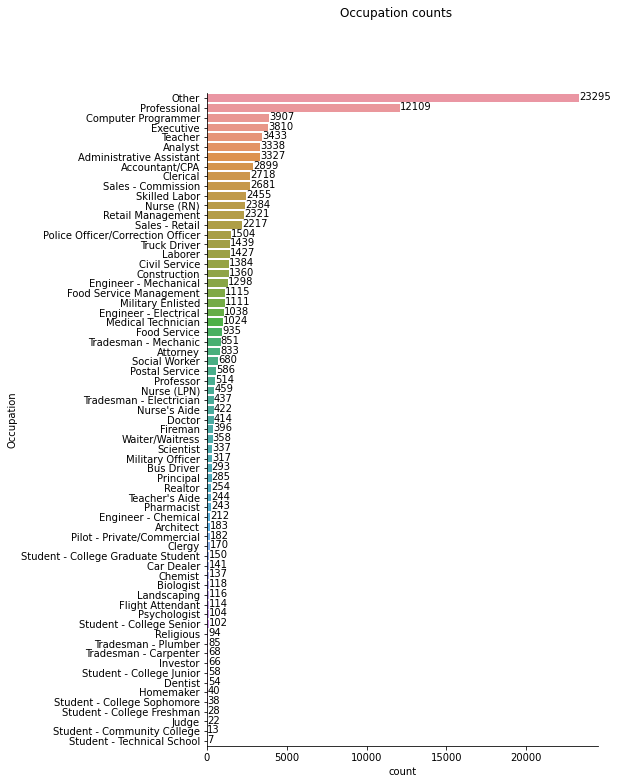

In [39]:
# subplots(row, col) , figsize(x,y)
fig, axes = plt.subplots(1,1, figsize=(7,12))
sb.despine(fig)

#axes.set(xscale="log")
g0 = sb.countplot(data=loans_df, 
                  y='Occupation',
                  order=loans_df.Occupation.value_counts().index)

# call function and plot values of graph
yplot_values(g0, '{:1.0f}')

fig.suptitle('Occupation counts')

plt.show();

The above graph shows several types of Occupations split to there appropriate position name, where as the top two occupations are ambigious and uninformative i.e. **Professionals** and **Other**.

As there several Occupations to display, it will be quite cumbersome to display all the statistical distributions of each, example seen below. 

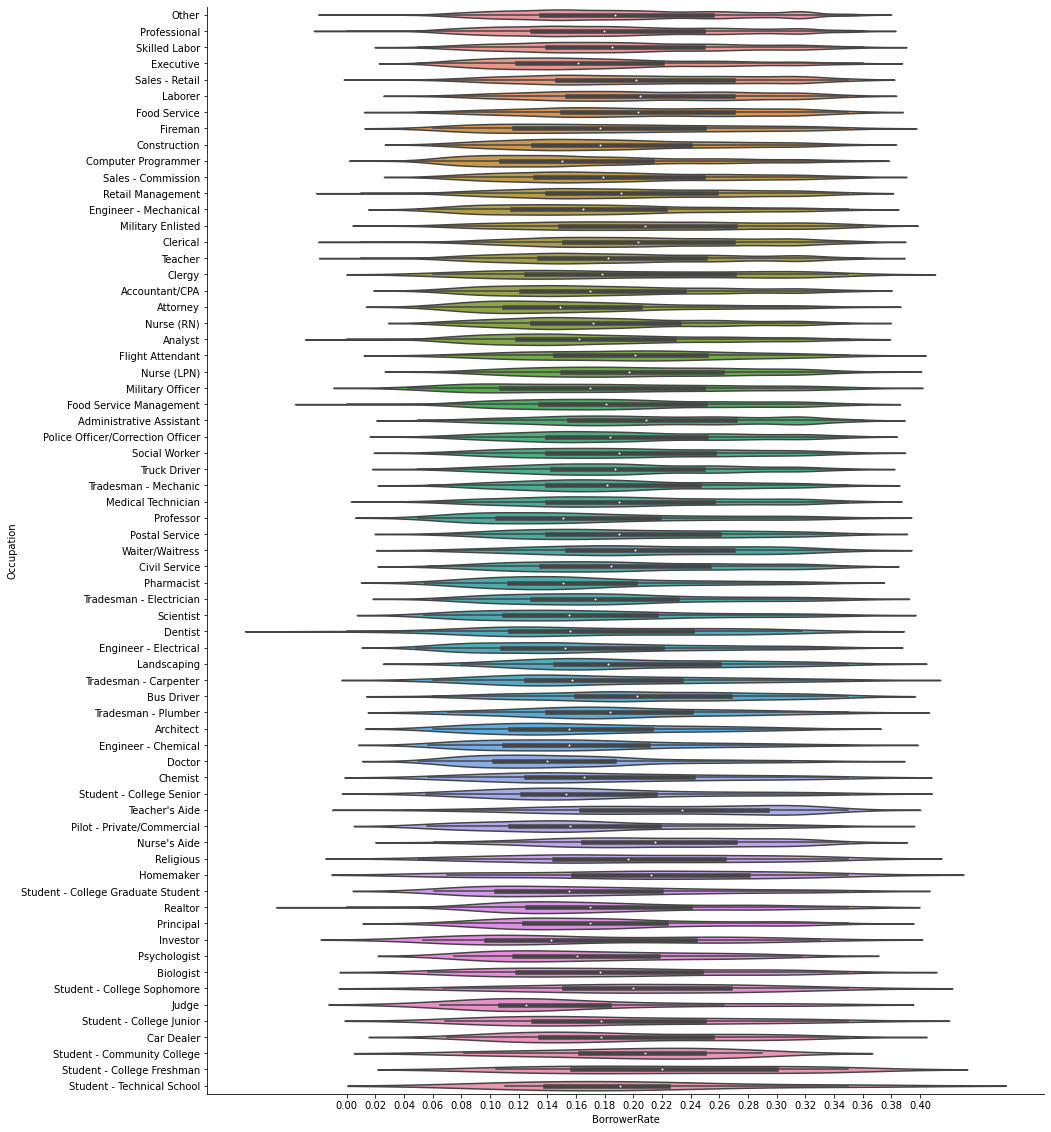

In [40]:
fig, axes = plt.subplots(1, 1, figsize=(15, 20))
sb.despine(fig)

xticks_range = np.arange(0, loans_df.BorrowerRate.max()+0.06, 0.02)

g0 = sb.violinplot(
      y = loans_df.Occupation,
      x = loans_df.BorrowerRate)
g0.set_xticks(xticks_range);

Violin plots dont provide a very accurate or good representation of the spread of occupations against borrow rate, evident with lines exceeding 0% as well as stretched plots not showing the width of per Occupation. Therefore the alternative will be boxplots as seen below.

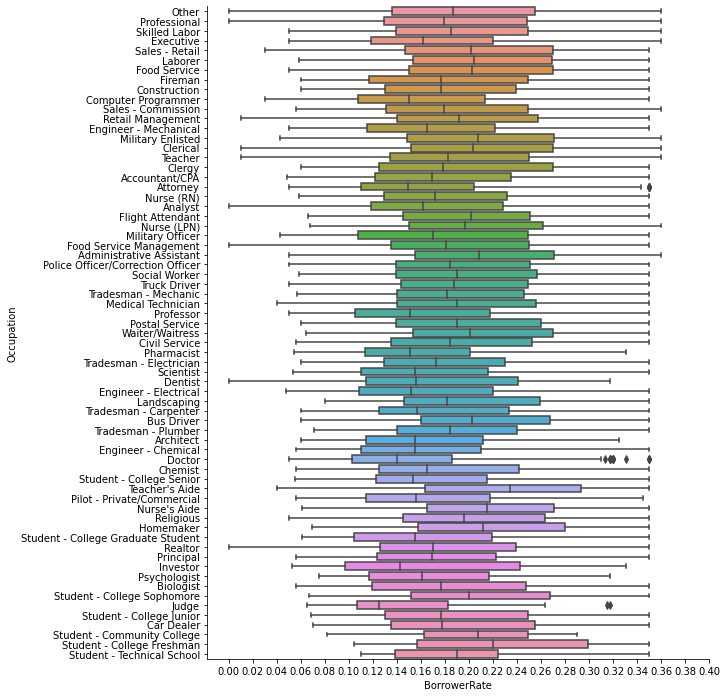

In [41]:
fig, axes = plt.subplots(1, 1, figsize=(9, 12))
sb.despine(fig)

xticks_range = np.arange(0, loans_df.BorrowerRate.max()+0.06, 0.02)

g0 = sb.boxplot(
      y= loans_df.Occupation,
      x = loans_df.BorrowerRate);
g0.set_xticks(xticks_range);

Using the box plot above, we can see a better capture of the **Occupations** relationship to Borrow Rate. It is particularly evident that **Occupations** do impact borrow rates evident with  **Judge** and **Doctors** appearing to have the lowest median borrow rates, where as **Student College Freshman** and **Teachers aid** appear to have the highest.

Due to the quantity of the Occupations list, a select few professions will be assessed to ensure a wide proportion of the population is captured. This selection is visual based with attempts to collect a low and high borrow rate of each field i.e. business, law, engineering, public service, admin, etc.


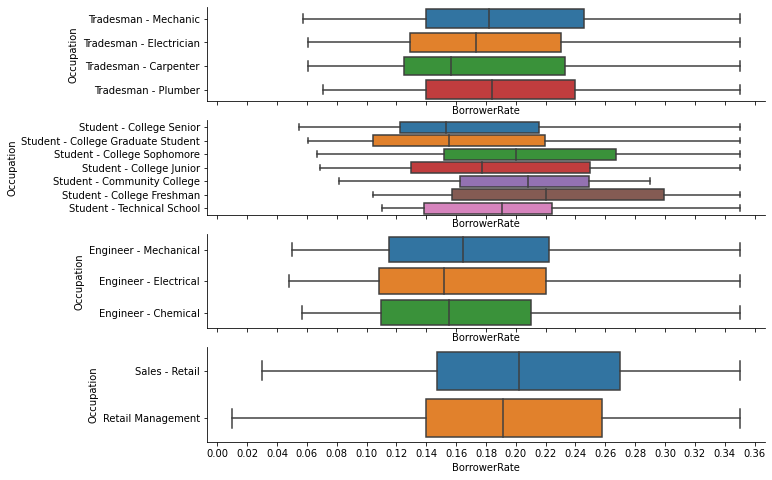

In [42]:
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
sb.despine(fig)

# filter by text
g0 = sb.boxplot(
      y= loans_df[loans_df['Occupation'].str.contains(pat='Trade',regex=False)].Occupation,
      x = loans_df.BorrowerRate,
      ax=axes[0])
# xticks_range defined in code block above
g0.set_xticks(xticks_range);

g1 = sb.boxplot(
      y= loans_df[loans_df['Occupation'].str.contains(pat='Student',regex=False)].Occupation,
      x = loans_df.BorrowerRate,
      ax=axes[1])

g2 = sb.boxplot(
      y= loans_df[loans_df['Occupation'].str.contains(pat='Engineer',regex=False)].Occupation,
      x = loans_df.BorrowerRate,
      ax=axes[2])

g3 = sb.boxplot(
      y= loans_df[loans_df['Occupation'].str.contains(pat='Retail',regex=False)].Occupation,
      x = loans_df.BorrowerRate,
      ax=axes[3])

In [43]:
key_occp_list = loans_df.Occupation.value_counts().index[2:11].to_list()

# custom selection of Occupations to incorporate one from each field of work
custom_occp_list = ['Police Officer/Correction Officer', 'Fireman', 
                    'Attorney', 'Engineer - Mechanical', 
                    'Doctor', 'Judge', 'Investor', 'Sales - Retail',
                    'Student - College Freshman', 'Student - College Graduate Student']

sample_occp_list = key_occp_list + custom_occp_list # append both lists into one
sample_occp_mask = loans_df.Occupation.isin(sample_occp_list)

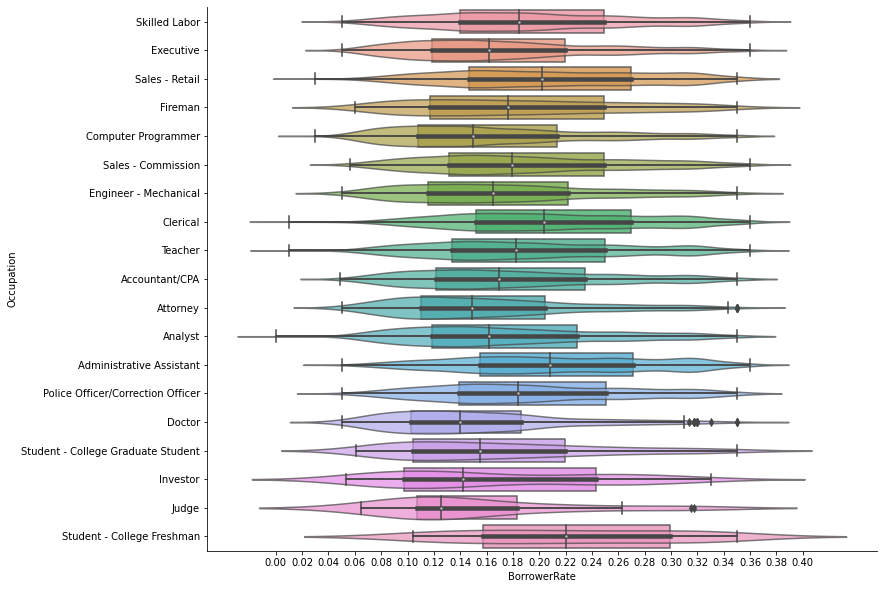

In [44]:
fig, axes = plt.subplots(1,1, figsize=(12,10))
sb.despine(fig)

#set range of x axis
xticks_range = np.arange(0, loans_df[sample_occp_mask].BorrowerRate.max()+0.06, 0.02)

g0 = sb.violinplot(
        y = loans_df[sample_occp_mask].Occupation,
        x = loans_df.BorrowerRate);
plt.setp(g0.collections, alpha=.7);
g1 = sb.boxplot(
        y = loans_df[sample_occp_mask].Occupation,
        x = loans_df.BorrowerRate,
        boxprops=dict(alpha=.8));
g1.set_xticks(xticks_range)

plt.show();

Initially the two plots were on separate subplots which made comparing them side by side difficult. As such combining them onto the same plot allows for a better visual of the width of the violins, as well as the outliers, lower and upper quartiles shown by the box plot. It is apparent Occupations do impact the borrow rates issued out by Prosper, next variable to investigate is **Income Range** which directly ties to the amount each occupation is paid.


Prior to dropping **Other** and **Professional** occupations, an investigation into the spread of data will be performed to determine how it sits when compared against **Borrower Rate**.

In [45]:
# taking note of current dataframe size
loans_df.shape

(94754, 14)

In [46]:
# the size based on the above filter
loans_df[sample_occp_mask].shape

(35496, 14)

In [47]:
# the size based on Other and Professional
sample_misc_loans = loans_df[loans_df.Occupation.isin(['Other', 'Professional'])] # get Occupations with Other and Professional
sample_misc_loans.shape

(35404, 14)

In [48]:
# the size of the remaining excluding other and Professional
sample_remain_loans = loans_df[(loans_df.Occupation!='Other') & (loans_df.Occupation!='Professional')]
sample_remain_loans.shape

(59350, 14)

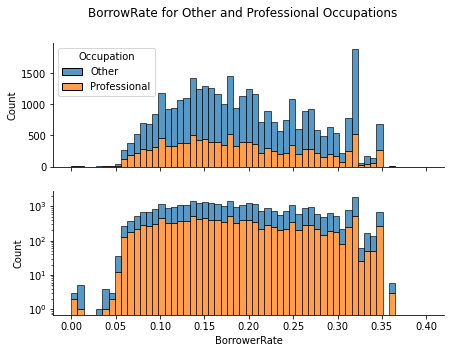

In [49]:
# plot to show the distribution of Other and Professional occupations
# subplots(row, col)
fig, axes = plt.subplots(2,1, figsize=(7,5), sharex=True)
sb.despine(fig)

# graph 1 - distribution of borrow rates
g1 = sb.histplot(sample_misc_loans, # new sample data frame above
        x='BorrowerRate',
        binrange=(0, 0.4),
        element='bars',
        hue='Occupation',
        multiple='stack',
        ax=axes[0]);

# graph 2 - log scale transformation of of graph 1 to assist in visualizing smaller values
axes[1].set(yscale="log")
g2 = sb.histplot(sample_misc_loans, 
        x='BorrowerRate',
        binrange=(0, 0.4), 
        element='bars',
        hue='Occupation',
        multiple='stack',
        ax=axes[1],
        legend=False);

# TODO - consolidate legend
fig.suptitle('BorrowRate for Other and Professional Occupations')

plt.show();

Before dropping **Other** and **Professional** occupations from the dataframe, we observe the plot above showing a normal distribution. and its potential influence to BorrowRate. The peak at ~32% would appear to the usual BorrowRate provided by Prosper.

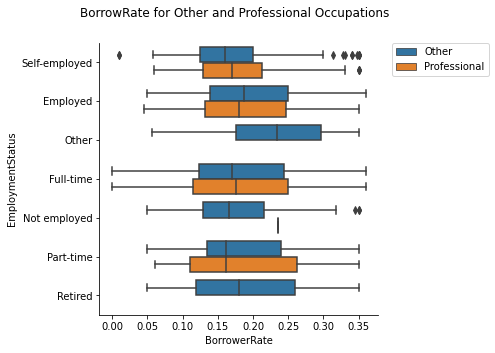

In [50]:
fig, axes = plt.subplots(1,1, figsize=(5,5))
sb.despine(fig)

xtick_range = np.arange(0, sample_misc_loans.BorrowerRate.max()+0.06, 0.02)

g0 = sb.boxplot(data = sample_misc_loans,
                x = 'BorrowerRate',
                y = 'EmploymentStatus',
                hue='Occupation'
                );
g0.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

fig.suptitle('BorrowRate for Other and Professional Occupations')

plt.show;

#### 2.1.4 IncomeRange

In [51]:
loans_df.IncomeRange.value_counts()

$50,000-74,999    28614
$25,000-49,999    28609
$100,000+         15870
$75,000-99,999    15739
$1-24,999          5866
Not employed         56
$0                    0
Name: IncomeRange, dtype: int64

Income range has already been categorized earlier in the exploration. However requires cleaning as evident with $0 and Not employed values.

In [52]:
# replace incorrect data
loans_df.IncomeRange = loans_df.IncomeRange.replace(['Not employed'], '$0')

In [53]:
# verify replacement was correct
loans_df.IncomeRange.value_counts()

$50,000-74,999    28614
$25,000-49,999    28609
$100,000+         15870
$75,000-99,999    15739
$1-24,999          5866
$0                   56
Name: IncomeRange, dtype: int64

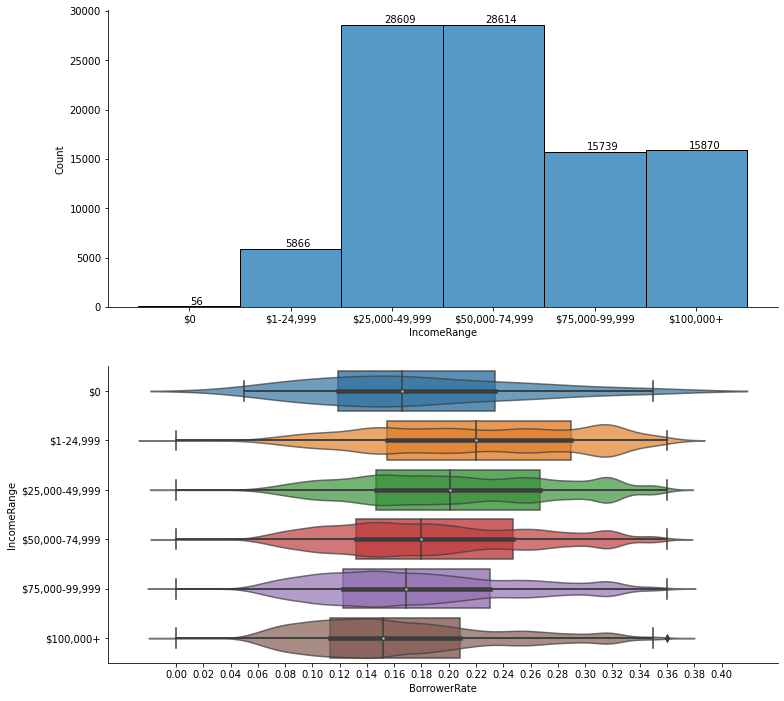

In [54]:
fig, axes = plt.subplots(2,1, figsize=(12, 12) )
sb.despine(fig)

# graph 1 - distribution of Income range
g0 = sb.histplot(
    data = loans_df, # new sample data frame above
    x = 'IncomeRange',
    element = 'bars',
    multiple = 'stack',
    ax = axes[0]);
xplot_values(g0, '{:1.0f}');

xticks_range = np.arange(0, loans_df.BorrowerRate.max()+0.06, 0.02)
# graph 2 - distribution of Income range
g1 = sb.violinplot(
    data = loans_df,
    x = 'BorrowerRate',
    y = 'IncomeRange',
    ax = axes[1]);
plt.setp(g1.collections, alpha=.7)
g1 = sb.boxplot(
    data = loans_df,
    x = 'BorrowerRate',
    y = 'IncomeRange',
    ax = axes[1],
    boxprops=dict(alpha=.8));
g1.set_xticks(xticks_range);

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


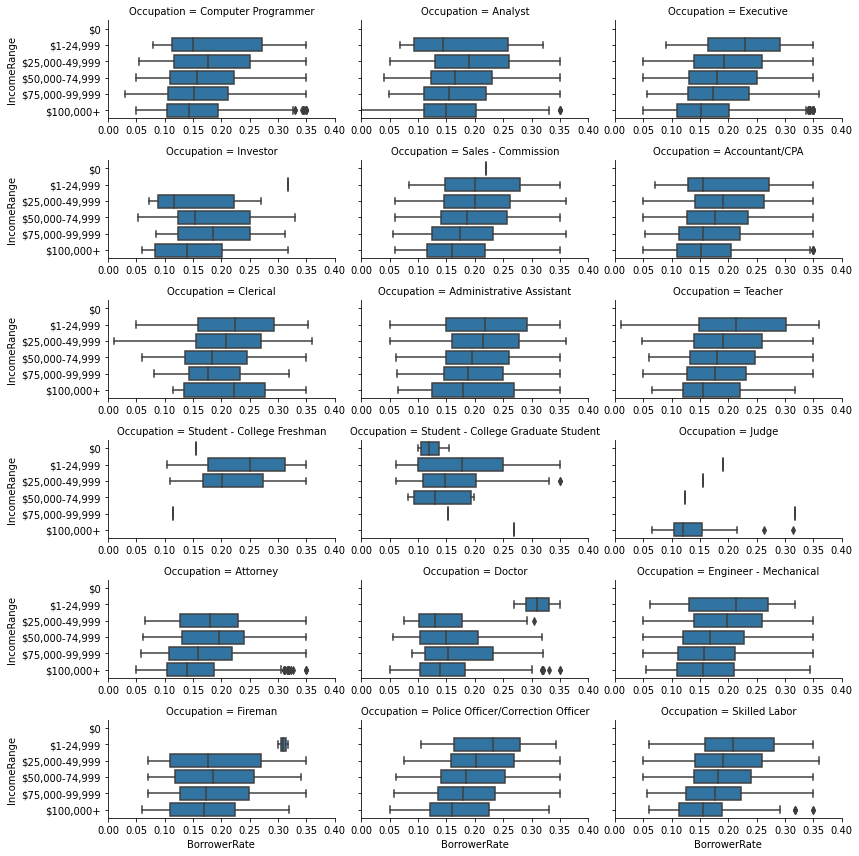

In [55]:
sb.despine(fig)

Occ_order=['Computer Programmer', 'Analyst',
           'Executive', 'Investor', 'Sales - Commission',
           'Accountant/CPA', 'Clerical', 'Administrative Assistant',
           'Teacher', 'Student - College Freshman', 'Student - College Graduate Student',
           'Judge', 'Attorney', 'Doctor', 'Engineer - Mechanical',
           'Fireman', 'Police Officer/Correction Officer', 'Skilled Labor']

# re-use previous list of Occupations to produce a multi-variate plot 

xticks_range = np.arange(0, loans_df.BorrowerRate.max()+0.05, 0.05)
g0 = sb.FacetGrid(data=loans_df[sample_occp_mask], col = 'Occupation',
                  col_wrap = 3, # number of columns before starting a new row
                  col_order = Occ_order,
                  sharex=False,
                  height=2,
                  aspect=2,
                  xlim=(0, 0.4),
                  margin_titles = True);
g0.map(sb.boxplot, 'BorrowerRate', 'IncomeRange');
g0.set(xticks=xticks_range);

From the above multi-variate above it is obvious to see that the higher income ranges, generally results in lower borrow rates.
The only exception to this are **Doctors**, **Clerical**, **Investors** and **Student - College Graduate Students**. 

#### 2.1.5 Monthly Loan Repayment

In [56]:
loans_df.Term.value_counts()

36    70455
60    22884
12     1415
Name: Term, dtype: int64

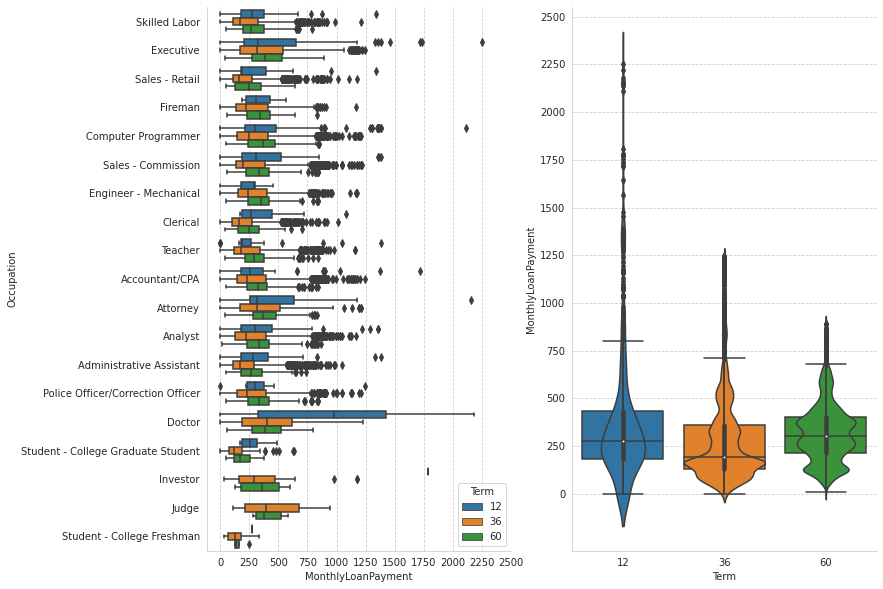

In [80]:
# set figure to have major grid lines
sb.set_style("whitegrid", {'grid.linestyle': '--'})
fig, axes = plt.subplots(1, 2, figsize=(12,10) )
sb.despine(fig)

# set custom labels to
xyticks_range = np.arange(0, loans_df.MonthlyLoanPayment.max()+250, 250)


g0 = sb.boxplot(
        x = loans_df['MonthlyLoanPayment'],
        y = loans_df[sample_occp_mask].Occupation, # sample list of occupations
        hue = loans_df['Term'],
        ax = axes[0])
g0.set_xticks(xyticks_range);

g1 = sb.violinplot(
        y = loans_df['MonthlyLoanPayment'],
        x = loans_df.Term,
        ax = axes[1])
g1 = sb.boxplot(
    y = loans_df['MonthlyLoanPayment'],
        x = loans_df.Term,
        ax = axes[1])
g1.set_yticks(xyticks_range);

The violin & box plot above reveals the majority of Prosper clients requiring loans prefer 36 month terms. The plot reveals a significant quantity of outliers within 12 month terms, afterwards the outliers gradually decrease as the terms increase. This reveals the volatility 

Text(0.5, 0.98, 'Repayments vs BorrowerRate vs Term')

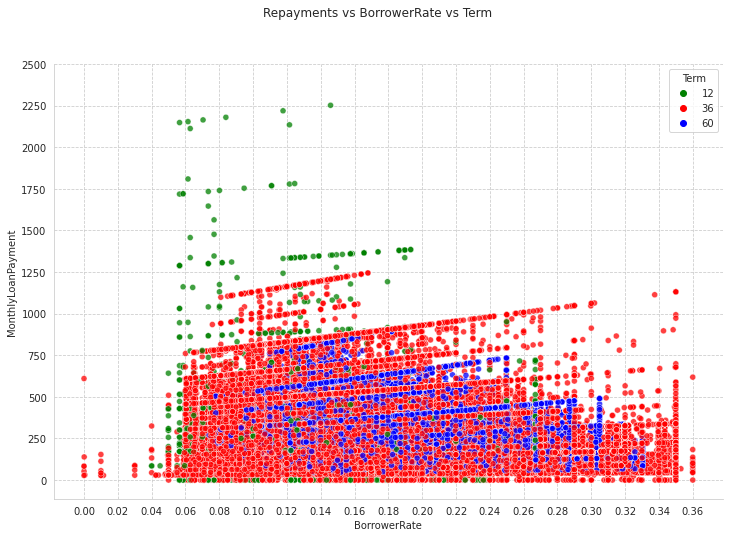

In [58]:
# define figure and num. axes
fig, axes = plt.subplots(1, 1, figsize=(12, 8) )
sb.despine(fig)

#define axis ticks
yticks_range = np.arange(0, loans_df.MonthlyLoanPayment.max()+250, 250)
xticks_range = np.arange(0, loans_df.BorrowerRate.max()+0.02, 0.02)

g0 = sb.scatterplot(y = loans_df['MonthlyLoanPayment'], 
                    x = loans_df.BorrowerRate, 
                    hue = loans_df.Term, 
                    ax = axes, 
                    palette=['green','red','blue'], alpha=0.75)
g0.set_xticks(xticks_range)
g0.set_yticks(yticks_range)

fig.suptitle('Repayments vs BorrowerRate vs Term')

plt.show();

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


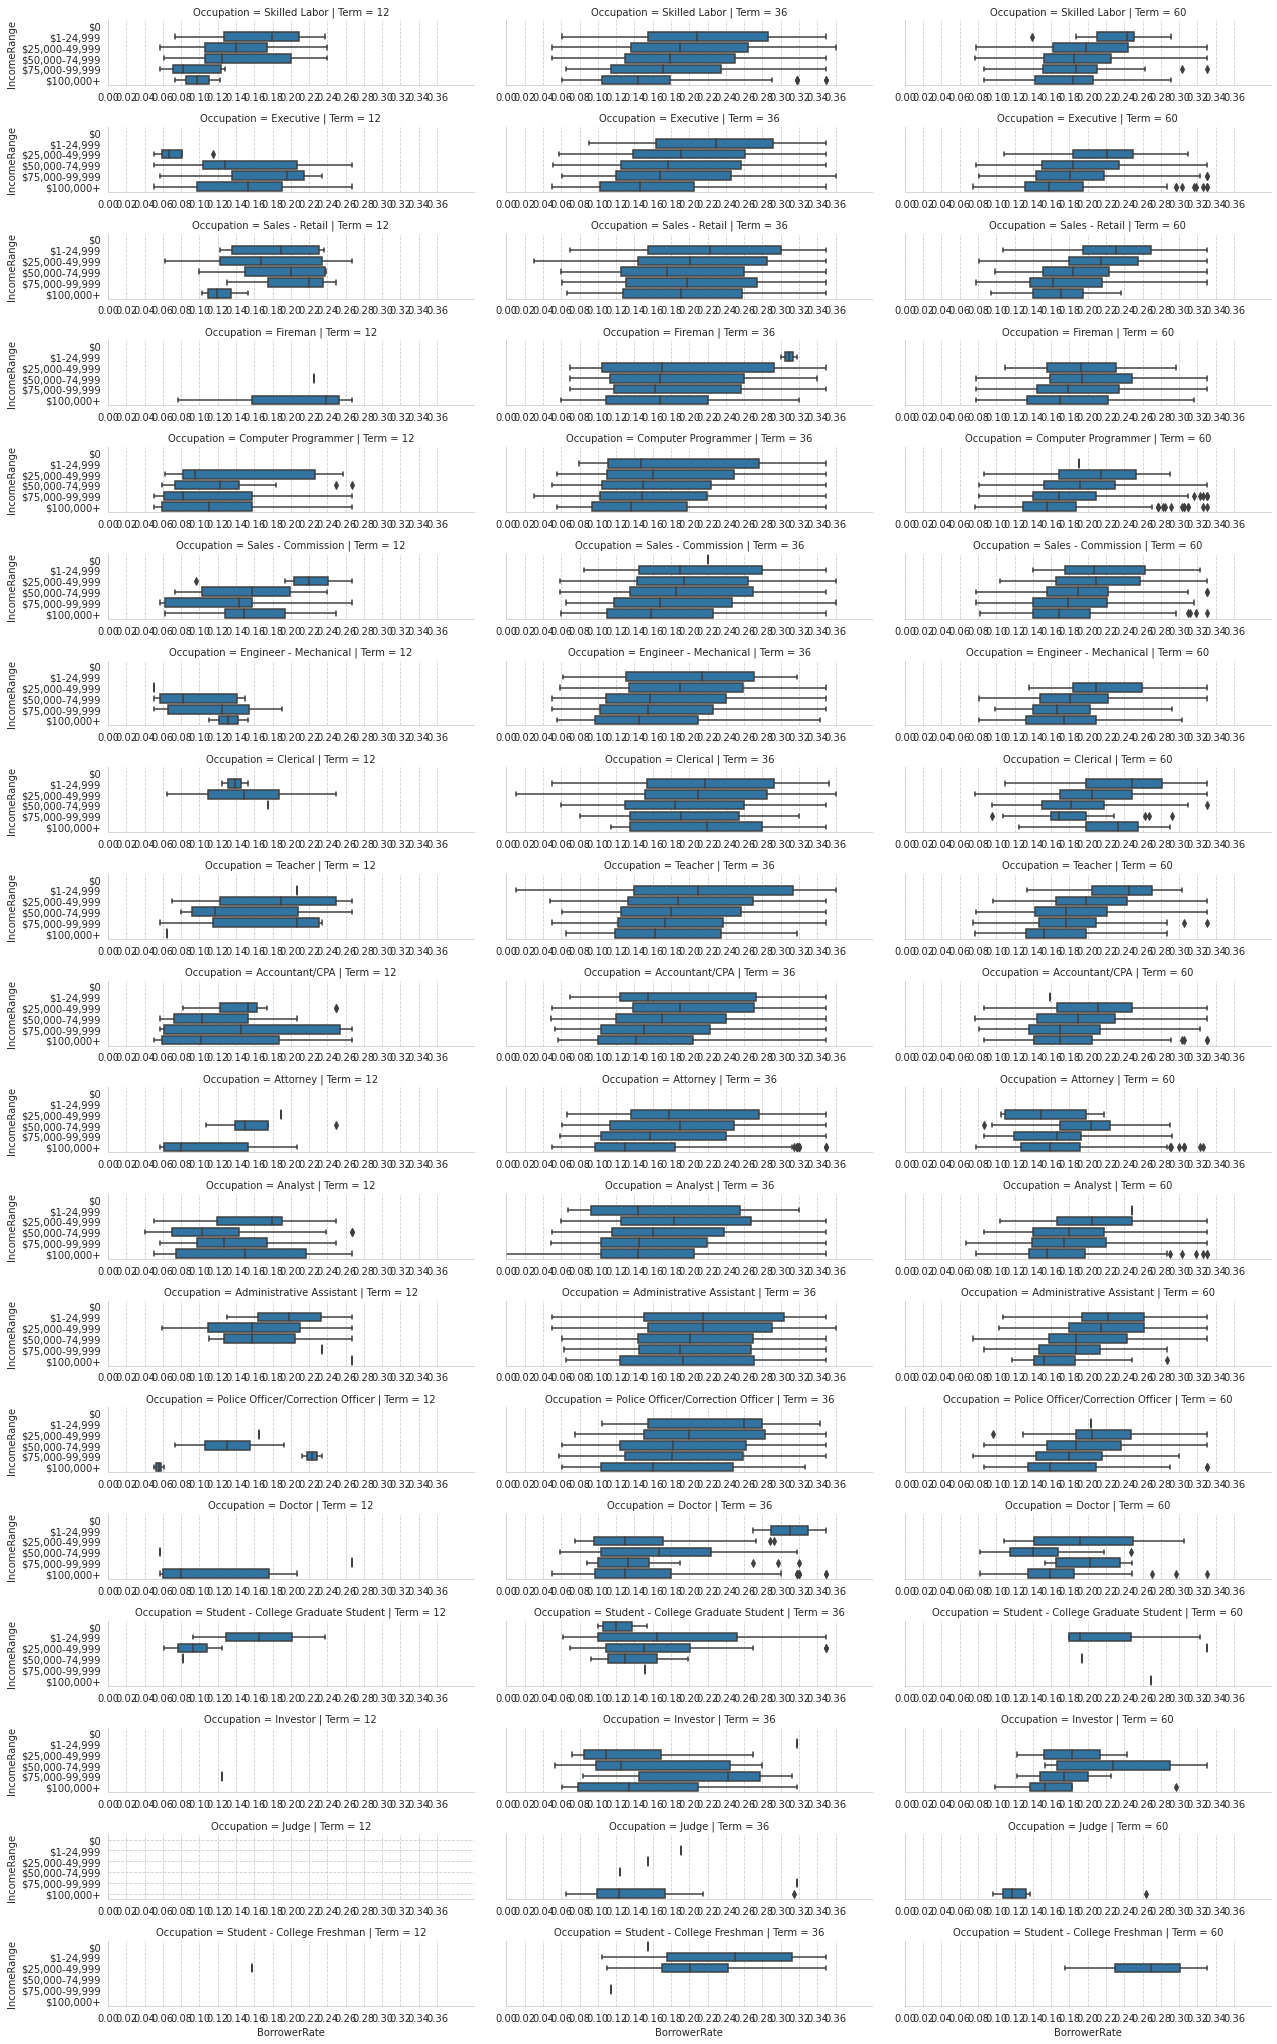

In [59]:
#xticks_range = np.arange(0, loans_df.BorrowerRate.max()+0.05, 0.05)
g0 = sb.FacetGrid(data=loans_df[sample_occp_mask], col = 'Term', row = 'Occupation',
                  sharex = False,
                  height = 1.5,
                  aspect = 4,
                  xlim = (0, 0.4),
                  legend_out = True);
g0.map(sb.boxplot, 'BorrowerRate', 'IncomeRange');
g0.set(xticks=xticks_range);

#### 2.1.6 ProsperRating

In [60]:
loans_df['ProsperRating (Alpha)'].value_counts(dropna=False)

NaN    18530
C      16501
B      14379
A      13491
D      12631
E       8443
HR      5682
AA      5097
Name: ProsperRating (Alpha), dtype: int64

In [61]:
loans_df.MonthlyLoanPayment.describe()

count    94754.000000
mean       282.757296
std        194.205174
min          0.000000
25%        140.610000
50%        234.500000
75%        381.320000
max       2251.510000
Name: MonthlyLoanPayment, dtype: float64

The most reoccurring monthly repayment revolves around 173.71.
With the median repayment rate at 225.

In [62]:
loans_df.MonthlyLoanPayment.median()

234.5

In [63]:
 loans_df.MonthlyLoanPayment.value_counts()

173.71    1929
0.00       733
172.76     460
86.85      402
174.20     353
          ... 
394.48       1
69.93        1
117.24       1
443.71       1
120.67       1
Name: MonthlyLoanPayment, Length: 20890, dtype: int64

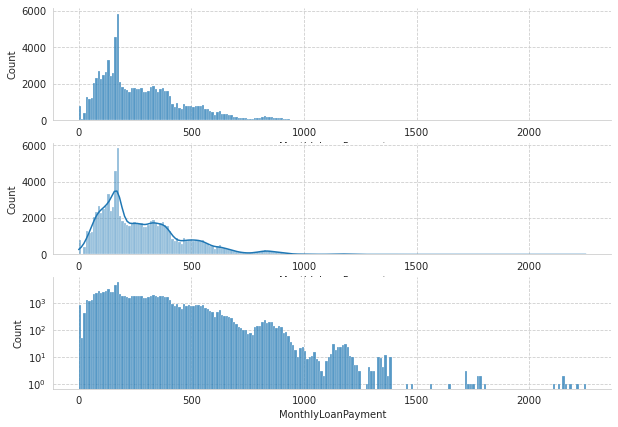

In [64]:
fig, axes = plt.subplots(3,1, figsize=(10,7))
sb.despine(fig)

# graph 1 - distribution of borrow rates
g0 = sb.histplot(loans_df,
        x='MonthlyLoanPayment',
        #binrange=(0, 0.4),
        element='bars',
        multiple="stack",
        ax=axes[0]);

g1 = sb.histplot(loans_df,
        x='MonthlyLoanPayment',
        #binrange=(0, 0.4),
        element='bars',
        kde=True,
        multiple="stack",
        ax=axes[1]);

axes[2].set(yscale="log")
g2 = sb.histplot(loans_df,
        x='MonthlyLoanPayment',
        #binrange=(0, 0.4),
        element='bars',
        multiple="stack",
        ax=axes[2]);

plt.show();

In [65]:
loans_df.MonthlyLoanPayment.max()

2251.51

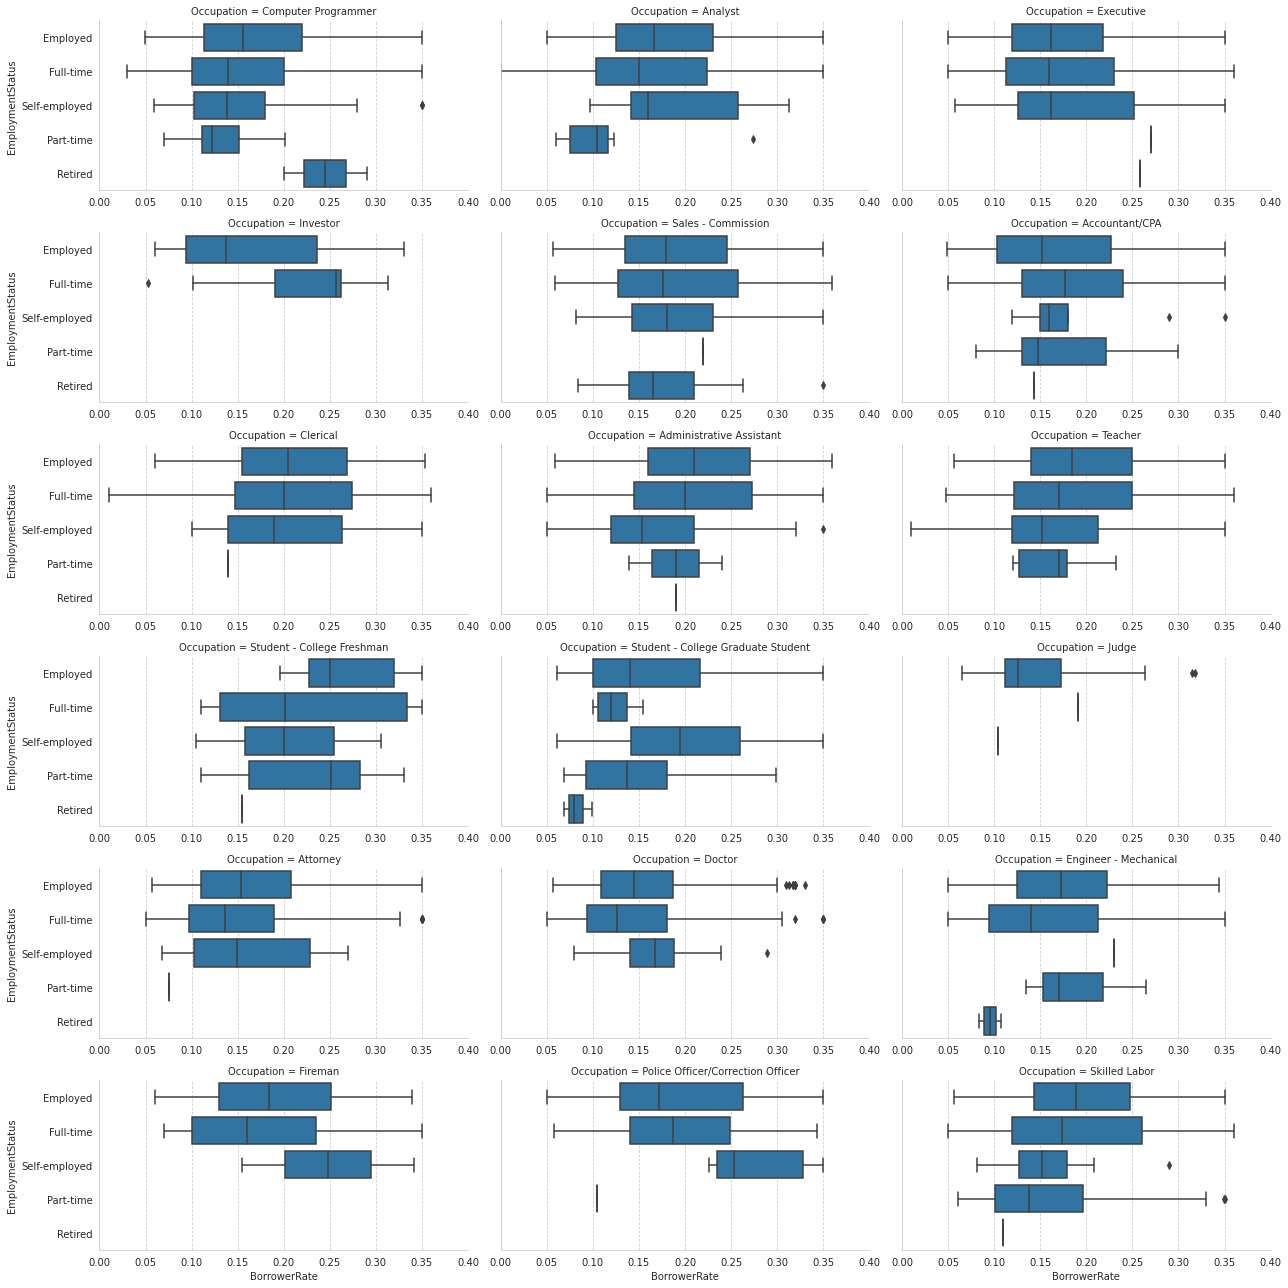

In [66]:
sb.despine(fig)

Occ_order=['Computer Programmer', 'Analyst',
           'Executive', 'Investor', 'Sales - Commission',
           'Accountant/CPA', 'Clerical', 'Administrative Assistant',
           'Teacher', 'Student - College Freshman', 'Student - College Graduate Student',
           'Judge', 'Attorney', 'Doctor', 'Engineer - Mechanical',
           'Fireman', 'Police Officer/Correction Officer', 'Skilled Labor']

g0 = sb.FacetGrid(data=loans_df[sample_occp_mask], col='Occupation', 
                  col_wrap=3, # number of columns before starting a new row
                  col_order = Occ_order,
                  #height=2,
                  aspect=2,
                  sharex=False,
                  xlim=(0,0.4),
                  margin_titles=True);
g0.map_dataframe(sb.boxplot, 'BorrowerRate', 'EmploymentStatus');

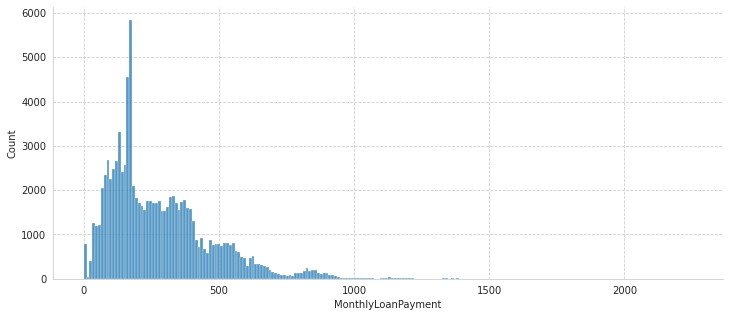

In [67]:
fig, axes = plt.subplots(1,1, figsize=(12,5))
sb.despine(fig)

# load df w/ mask
g0 = sb.histplot(loans_df.MonthlyLoanPayment)

In [68]:
loans_df.MonthlyLoanPayment.value_counts()

173.71    1929
0.00       733
172.76     460
86.85      402
174.20     353
          ... 
394.48       1
69.93        1
117.24       1
443.71       1
120.67       1
Name: MonthlyLoanPayment, Length: 20890, dtype: int64

#### 2.1.X BorrowerState

In [69]:
# top X states
states=5 # user to change

StateTopN = loans_df.BorrowerState.value_counts().head(states)
StateTopN

CA    12649
NY     5898
FL     5789
TX     5618
IL     5250
Name: BorrowerState, dtype: int64

In [70]:
state_N_mask = loans_df['BorrowerState'].isin(StateTopN.index)

In [71]:
loans_df[state_N_mask].sample(5)

,EmploymentStatus,BorrowerState,Occupation,CreditGrade,ProsperScore,ProsperRating (Alpha),IncomeRange,Term,CurrentDelinquencies,BorrowerRate,DebtToIncomeRatio,ListingCreationDate,ClosedDate,MonthlyLoanPayment
63078,Employed,NY,Other,NaN,8.0,B,"$100,000+",36,0.0,0.1299,0.22,2010-12-21 12:55:09.470,2012-09-19,252.67
96638,Employed,NY,Retail Management,NaN,8.0,D,"$50,000-74,999",36,0.0,0.2419,0.27,2013-08-15 19:51:30.923,NaT,589.99
32046,Employed,FL,Professional,NaN,9.0,A,"$50,000-74,999",60,0.0,0.1364,0.13,2012-09-15 08:57:39.320,NaT,161.57
17495,Employed,TX,Skilled Labor,NaN,8.0,A,"$75,000-99,999",36,0.0,0.1089,0.14,2013-07-11 13:25:01.353,NaT,212.46
110343,Employed,FL,Realtor,NaN,5.0,E,"$25,000-49,999",36,1.0,0.2969,0.25,2012-09-24 18:28:13.600,2013-04-05,169.13


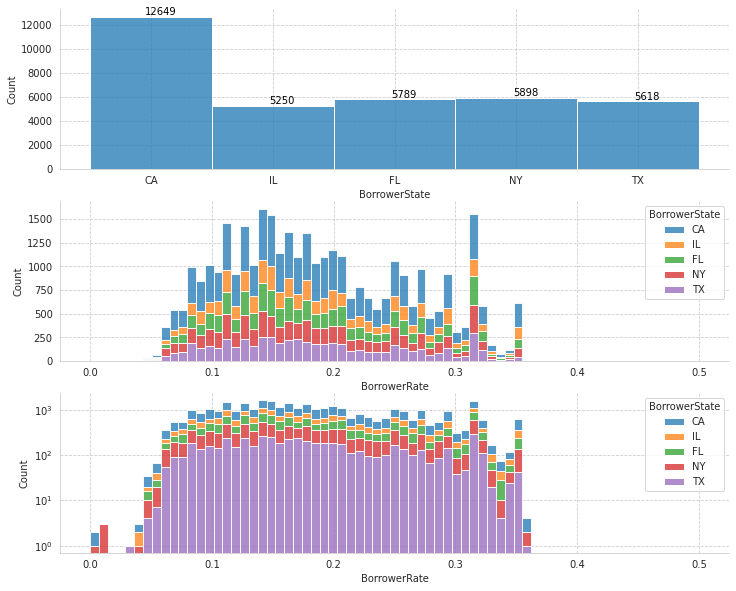

In [72]:
fig, axes = plt.subplots(3,1, figsize=(12,10))
sb.despine(fig)

g0 = sb.histplot(loans_df[state_N_mask],
        x='BorrowerState', 
        ax=axes[0]);
xplot_values(g0, '{:1.0f}')

# load df w/ mask
g1 = sb.histplot(loans_df[state_N_mask], 
        x='BorrowerRate',
        binrange=(0, 0.5),
        element='bars',
        stat='count',
        hue='BorrowerState',
        multiple="stack",
        ax=axes[1])

axes[2].set(yscale="log")
## CHANGE Y TICK NUMBERS
g2 = sb.histplot(loans_df[state_N_mask],
        x='BorrowerRate',
        binrange=(0, 0.5),
        element='bars',
        stat='count',
        hue='BorrowerState',
        multiple="stack",
        ax=axes[2])

In [73]:
hm_loans_df = loans_df[['BorrowerRate', 'BorrowerState']][state_N_mask]
hm_loans_df

,BorrowerRate,BorrowerState
7,0.2019,CA
8,0.0629,IL
9,0.0629,IL
15,0.3177,FL
16,0.2809,CA
...,...,...
113929,0.2639,FL
113931,0.1274,IL
113932,0.1864,IL
113934,0.2150,TX


#### Debt to Income Ratio

In [74]:
loans_df.DebtToIncomeRatio.value_counts()

0.18    3792
0.22    3474
0.17    3307
0.14    3252
0.20    3094
        ... 
1.94       1
4.19       1
1.28       1
6.95       1
2.07       1
Name: DebtToIncomeRatio, Length: 311, dtype: int64

#### 2.1.X Credit Grade

In [75]:
loans_df.CreditGrade.value_counts()

C     4012
D     3394
B     3092
AA    2392
A     2348
HR    1589
E     1583
Name: CreditGrade, dtype: int64

In [76]:
loans_df.columns

Index(['EmploymentStatus', 'BorrowerState', 'Occupation', 'CreditGrade',
       'ProsperScore', 'ProsperRating (Alpha)', 'IncomeRange', 'Term',
       'CurrentDelinquencies', 'BorrowerRate', 'DebtToIncomeRatio',
       'ListingCreationDate', 'ClosedDate', 'MonthlyLoanPayment'],
      dtype='object')

In [77]:
loans_df.CreditGrade.value_counts(dropna=False)

NaN    76344
C       4012
D       3394
B       3092
AA      2392
A       2348
HR      1589
E       1583
Name: CreditGrade, dtype: int64

In [78]:
loans_df.CreditGrade = loans_df.CreditGrade.fillna('N/A')

ValueError: ignored

### ClosedDate

In [ ]:
loans_df.ClosedDate.value_counts(dropna=False)
# There are a significant amount of NaT, i.e. 58848